# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import string
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df= pd.read_csv('/content/drive/MyDrive/toxicity_analysis_dataset.csv')

In [4]:
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# EDA

In [5]:
#Dataset is too large so we are taking 70000 entries only
df = df.sample(n=70000, random_state=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70000 entries, 24915 to 104879
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             70000 non-null  object
 1   comment_text   70000 non-null  object
 2   toxic          70000 non-null  int64 
 3   severe_toxic   70000 non-null  int64 
 4   obscene        70000 non-null  int64 
 5   threat         70000 non-null  int64 
 6   insult         70000 non-null  int64 
 7   identity_hate  70000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 4.8+ MB


In [7]:
# List of target columns
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
class_counts = df[target_columns].sum()
print(class_counts)

toxic            6804
severe_toxic      713
obscene          3713
threat            215
insult           3489
identity_hate     633
dtype: int64


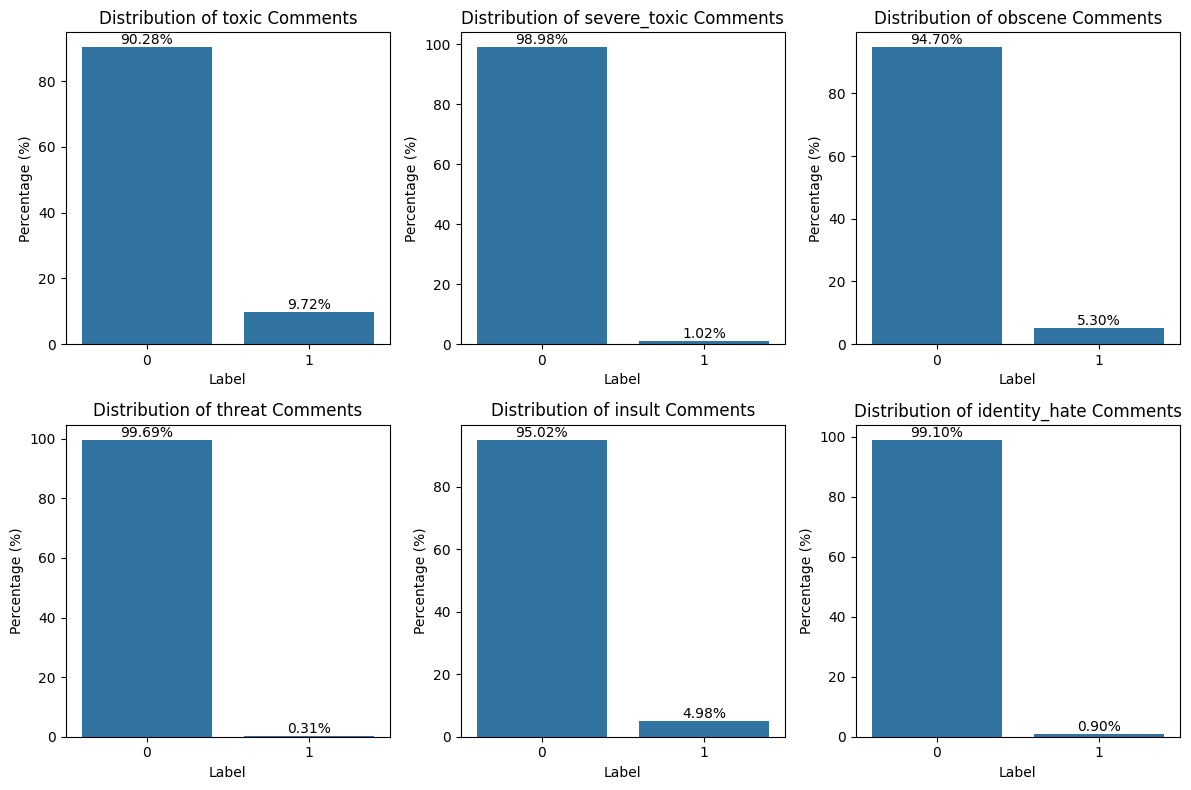

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Loop through each target column
for i, col in enumerate(target_columns):
    counts = df[col].value_counts(normalize=True) * 100
    # Create a new subplot
    plt.subplot(2, 3, i + 1)
    sns.barplot(x=counts.index, y=counts.values)
    # Annotate the bars with percentage values
    for index, value in enumerate(counts.values):
        plt.text(index, value, f'{value:.2f}%', ha='center', va='bottom')

    plt.title(f'Distribution of {col} Comments')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Label')

plt.tight_layout()
plt.show()


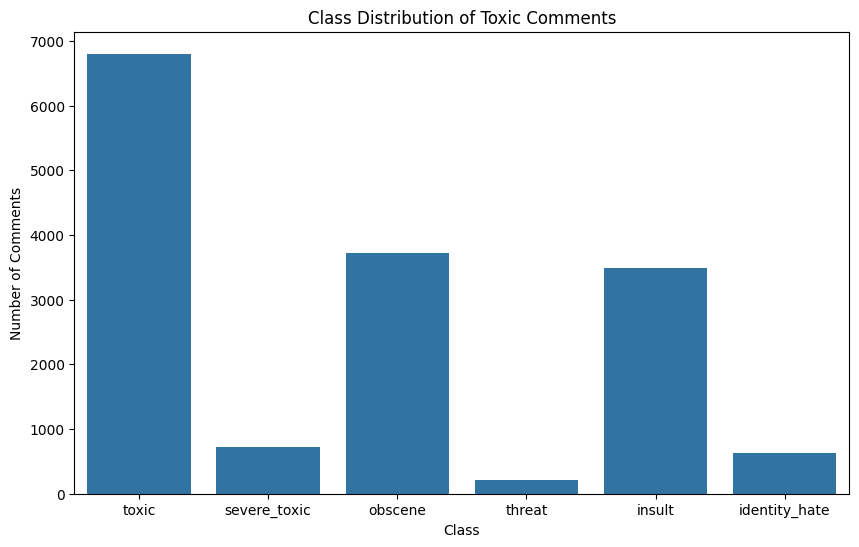

In [9]:
# Plot the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution of Toxic Comments')
plt.xlabel('Class')
plt.ylabel('Number of Comments')
plt.show()

In [10]:
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Count the number of labels per comment
df['label_count'] = df[target_columns].sum(axis=1)
df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_count
24915,41e65f43c180838e,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1,1,1,0,1,0,4
75819,cade9e425d75948e,Agent X2: Basically thanks - with a 'little' m...,0,0,0,0,0,0,0
53891,8ff87747403ed2e6,Why are my posts being deleted? \n\nI have tri...,0,0,0,0,0,0,0
154159,a95604c7a938abb3,"""\n\n Controlled Demolitions and Common Sense ...",0,0,0,0,0,0,0
13040,2288910537399728,I do not understand your reply. //Blaxthos ( ...,0,0,0,0,0,0,0


In [11]:
df['all_classes'] = df[target_columns].sum(axis=1) == 6
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_count,all_classes
24915,41e65f43c180838e,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1,1,1,0,1,0,4,False
75819,cade9e425d75948e,Agent X2: Basically thanks - with a 'little' m...,0,0,0,0,0,0,0,False
53891,8ff87747403ed2e6,Why are my posts being deleted? \n\nI have tri...,0,0,0,0,0,0,0,False
154159,a95604c7a938abb3,"""\n\n Controlled Demolitions and Common Sense ...",0,0,0,0,0,0,0,False
13040,2288910537399728,I do not understand your reply. //Blaxthos ( ...,0,0,0,0,0,0,0,False


In [12]:
all_classes_count = df['all_classes'].sum()
print(f"Number of comments that belong to all classes: {all_classes_count}")


Number of comments that belong to all classes: 15


In [13]:
df['comment_length'] = df['comment_text'].apply(len)

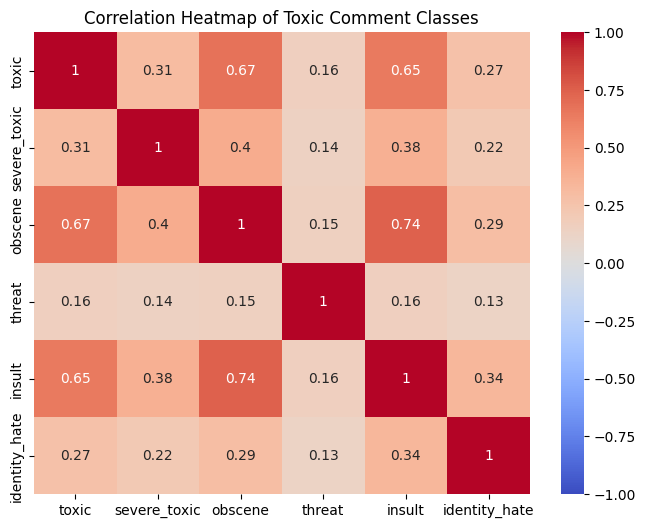

In [14]:
# Calculate the correlation matrix for the target columns and generate the heatmap
correlation_matrix = df[target_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Toxic Comment Classes')
plt.show()

In [15]:
from wordcloud import STOPWORDS
def generate_word_cloud(text, col):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word cloud for {col} comments', size=20)
    plt.axis('off')
    plt.show()

Enter class name to generate wordcloud: threat


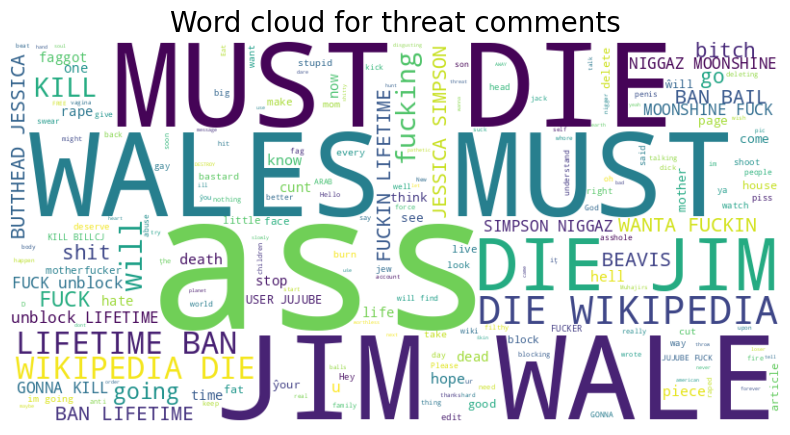

In [16]:
# Generate and display the word cloud
col_for_wordcloud = input("Enter class name to generate wordcloud: ")
class_comments = df[df[col_for_wordcloud] == 1]['comment_text']
class_comments_text = ' '.join(class_comments)
generate_word_cloud(class_comments_text, col_for_wordcloud)

In [17]:
df.loc[1	, 'comment_text']

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

# Pre-processing

In [18]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def preprocessing(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove numeric values
    text = re.sub(r'\d+', '', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation and len(word) > 1]

    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into text
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

df['comment_text'] = df['comment_text'].apply(preprocessing)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
df.loc[1	, 'comment_text']

"d'aww match background colour 'm seemingly stuck thanks talk january utc"

# Models

**Implementing TF-IDF**

In [20]:
# Define the feature and target variables
comments = df['comment_text']
cols = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(comments, cols, test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer with optimization parameters
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7)

# Fit the vectorizer on the training data and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the fitted vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

**1. Naive Bayes Classifier**

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report


In [22]:
# Initializing MultiOutputClassifier with Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_multi_classifier = MultiOutputClassifier(nb_classifier)

# Fit MultiOutputClassifier with Naive Bayes model
nb_multi_classifier.fit(X_train_tfidf, y_train)

# Prediction on the test set
nb_multi_y_pred = nb_multi_classifier.predict(X_test_tfidf)

# Evaluatation
nb_multi_accuracy = accuracy_score(y_test, nb_multi_y_pred)
print("\nNaive Bayes Multi-label Accuracy:", nb_multi_accuracy)
print("Naive Bayes Multi-label Classification Report:")
print(classification_report(y_test, nb_multi_y_pred, target_names=target_columns,zero_division=1))



Naive Bayes Multi-label Accuracy: 0.9144285714285715
Naive Bayes Multi-label Classification Report:
               precision    recall  f1-score   support

        toxic       0.93      0.49      0.65      1326
 severe_toxic       0.54      0.05      0.09       135
      obscene       0.92      0.54      0.68       705
       threat       1.00      0.00      0.00        40
       insult       0.84      0.43      0.57       676
identity_hate       0.80      0.03      0.07       117

    micro avg       0.90      0.45      0.60      2999
    macro avg       0.84      0.26      0.34      2999
 weighted avg       0.89      0.45      0.58      2999
  samples avg       0.99      0.94      0.93      2999



**2. Random Forest  Classifier**

In [23]:
from sklearn.ensemble import RandomForestClassifier
# Initialize MultiOutputClassifier with Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_multi_classifier = MultiOutputClassifier(rf_classifier, n_jobs=-1)

# Fit MultiOutputClassifier with Random Forest model
rf_multi_classifier.fit(X_train_tfidf, y_train)

# Predict on the test set
rf_multi_y_pred = rf_multi_classifier.predict(X_test_tfidf)

# Evaluate MultiOutputClassifier with Random Forest model
rf_multi_accuracy = accuracy_score(y_test, rf_multi_y_pred)
print("Random Forest Multi-label Accuracy:", rf_multi_accuracy)
print("Random Forest Multi-label Classification Report:")
print(classification_report(y_test, rf_multi_y_pred, target_names=target_columns,zero_division=1))


Random Forest Multi-label Accuracy: 0.9170714285714285
Random Forest Multi-label Classification Report:
               precision    recall  f1-score   support

        toxic       0.86      0.66      0.74      1326
 severe_toxic       0.41      0.05      0.09       135
      obscene       0.82      0.74      0.78       705
       threat       1.00      0.00      0.00        40
       insult       0.73      0.58      0.64       676
identity_hate       0.68      0.15      0.24       117

    micro avg       0.81      0.60      0.69      2999
    macro avg       0.75      0.36      0.42      2999
 weighted avg       0.79      0.60      0.67      2999
  samples avg       0.98      0.95      0.94      2999



**3. Light GBM classifier**

In [24]:
from lightgbm import LGBMClassifier
# Initialize MultiOutputClassifier with LightGBM classifier
lgbm_classifier = LGBMClassifier(random_state=42, n_estimators=200)
lgbm_multi_classifier = MultiOutputClassifier(lgbm_classifier, n_jobs=-1)

# Fit MultiOutputClassifier with LightGBM model
lgbm_multi_classifier.fit(X_train_tfidf, y_train)

# Predict on the test set
lgbm_multi_y_pred = lgbm_multi_classifier.predict(X_test_tfidf)

# Evaluate MultiOutputClassifier with LightGBM model
lgbm_multi_accuracy = accuracy_score(y_test, lgbm_multi_y_pred)
print("\nLightGBM Multi-label Accuracy:", lgbm_multi_accuracy)
print("LightGBM Multi-label Classification Report:")
print(classification_report(y_test, lgbm_multi_y_pred, target_names=target_columns,zero_division=1))




LightGBM Multi-label Accuracy: 0.9190714285714285
LightGBM Multi-label Classification Report:
               precision    recall  f1-score   support

        toxic       0.87      0.66      0.75      1326
 severe_toxic       0.40      0.24      0.30       135
      obscene       0.85      0.75      0.80       705
       threat       0.50      0.12      0.20        40
       insult       0.73      0.61      0.66       676
identity_hate       0.50      0.26      0.35       117

    micro avg       0.80      0.63      0.70      2999
    macro avg       0.64      0.44      0.51      2999
 weighted avg       0.79      0.63      0.70      2999
  samples avg       0.98      0.95      0.95      2999



## Conclusion

### Key Findings
With LGBM we achieved the highest multi-label accuracy of 0.919 and demonstrated superior performance across most categories, with notable F1 scores for toxic (0.75), obscene (0.79), and insult (0.66).

The superior performance of LightGBM in our analysis suggests that it is a highly effective model for text classification tasks in NLP.

### Future Work
While LightGBM showed the best performance, there are several areas for future improvement:
- **Hyperparameter Tuning**: Further tuning of model hyperparameters could enhance performance.
- **Real-time Application**: Implement and test the model in real-time environments to evaluate its practical use and performance.
- **Video Analysis**: Extend toxicity analysis to social media videos by analyzing audio and visual content to detect toxic behavior, enhancing platform safety.